# Matcha-chart2text-pew

Note
- Visual Encoder. Trained on pew dataset
- Have similar model but trained with statista dataset
- The very first 100 dataset of chartqa is more similar to pew dataset. It is possible that some of the latter part is statista (need to see into it)

In [1]:
from transformers import Pix2StructProcessor, Pix2StructForConditionalGeneration, AutoModelForCausalLM, AutoTokenizer
# from conversation import get_default_conv_template
import torch
import cv2
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

c:\Users\Neo\anaconda3\envs\dsai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [2]:
chartsum_model_ids = 'google/matcha-chart2text-pew'
# chartsum_model_ids = 'google/matcha-chart2text-statista'

processor = Pix2StructProcessor.from_pretrained(chartsum_model_ids)
model = Pix2StructForConditionalGeneration.from_pretrained(chartsum_model_ids)

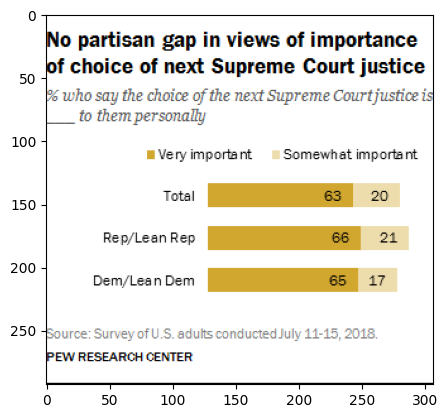

In [3]:
image = cv2.imread("./content/images/5061.png", cv2.IMREAD_COLOR)
# converting BGR to RGB 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)

In [4]:
# from PIL import Image
# import requests

# url = "https://raw.githubusercontent.com/vis-nlp/ChartQA/main/ChartQA%20Dataset/train/png/00035547003867.png"
# image = Image.open(requests.get(url, stream=True).raw)

In [5]:
# display(image)

In [6]:
chart_sum_prompts = ["What is this chart about?",
                      "Translate the numerical information depicted in the chart into a comprehensive textual summary. Describe the main patterns, variations, and relationships evident in the data."]
prompt_sum_pairs = []

for p in chart_sum_prompts:
    inputs = processor(images=image, text=p, return_tensors="pt")
    predictions = model.generate(**inputs, max_new_tokens=512)
    chart_sum = processor.decode(predictions[0], skip_special_tokens=True)
    prompt_sum_pairs.append({"prompt": p,
                             "sum": chart_sum})
    print(f"Chart summarizer prompt: {p}\nChart summary: {chart_sum}\n")

Chart summarizer prompt: What is this chart about?
Chart summary: The public is divided over the importance of the choice of the next Supreme Court justice: 63% say it is very important, while 20% say it is somewhat important.<0x0A>About half of Republicans and Republican leaners (66%) say the choice of the next Supreme Court justice is very important to them personally, with 21% saying it is somewhat important.<0x0A>Democrats and Democratic leaners are far more likely than Republicans and GOP leaners to say the choice of the next Supreme Court justice is very important to them personally (65% vs. 17%).

Chart summarizer prompt: Translate the numerical information depicted in the chart into a comprehensive textual summary. Describe the main patterns, variations, and relationships evident in the data.
Chart summary: A large majority of Americans (83%) say the choice of the next Supreme Court justice is either very or somewhat important to them personally, with 63% saying it is very impo

In [7]:
# MiniChat
tokenizer = AutoTokenizer.from_pretrained("GeneZC/MiniChat-3B", use_fast=False)
# GPU.
model = AutoModelForCausalLM.from_pretrained("GeneZC/MiniChat-3B", use_cache=True, device_map="auto", torch_dtype=torch.float16).eval()

# conv = get_default_conv_template("minichat")

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [8]:
def prompt_formatting(summary, question):
    return f"""
Below is a summary that describes a chart, paired with a question the user has about the chart. Write a response that appropriately answer the question.

### Summary:
{summary}

### Question:
{question}

### Response:
""".strip()

In [12]:
outputs = []

for pair in prompt_sum_pairs:
    prompt = prompt_formatting(
        pair['sum'],
        "Is the choice of next supreme court justice important for the democrats?")
    # conv.append_message(conv.roles[0], user_input)
    # conv.append_message(conv.roles[1], None)
    # prompt = conv.get_prompt()
    input_ids = tokenizer([prompt]).input_ids
    output_ids = model.generate(
        torch.as_tensor(input_ids).cuda(),
        do_sample=True,
        temperature=0.7,
        max_new_tokens=512,
    )
    output_ids = output_ids[0][len(input_ids[0]):]
    output = tokenizer.decode(output_ids, skip_special_tokens=True).strip()
    outputs.append(output)
    print(f"Chart summarizer prompt: {pair['prompt']}\nChart summary: {pair['sum']}\nAnswer: {output}\n")

Chart summarizer prompt: What is this chart about?
Chart summary: The public is divided over the importance of the choice of the next Supreme Court justice: 63% say it is very important, while 20% say it is somewhat important.<0x0A>About half of Republicans and Republican leaners (66%) say the choice of the next Supreme Court justice is very important to them personally, with 21% saying it is somewhat important.<0x0A>Democrats and Democratic leaners are far more likely than Republicans and GOP leaners to say the choice of the next Supreme Court justice is very important to them personally (65% vs. 17%).
Answer: Yes, the choice of the next Supreme Court justice is important for Democrats. Democrats and Democratic leaners are far more likely than Republicans and GOP leaners to say the choice of the next Supreme Court justice is very important to them personally (65% vs. 17%).

Chart summarizer prompt: Translate the numerical information depicted in the chart into a comprehensive textual 